In [1]:
!pip install rdkit
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install joblib
!pip install flask

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import joblib
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

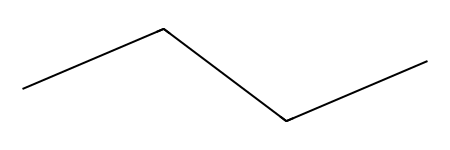

In [3]:
mol = Chem.MolFromSmiles('CCCC')
mol

In [4]:
#!/usr/bin/env python
import pandas as pd
import numpy as np

# RDKit for SMILES parsing
from rdkit import Chem
from rdkit.Chem import AllChem

# For train-test split, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For PLS regression
from sklearn.cross_decomposition import PLSRegression

# (Optional) Feature scaling if you want to standardize descriptors
# from sklearn.preprocessing import StandardScaler

def smiles_to_morgan_fp(smi, radius=2, n_bits=1024):
    """
    Convert a SMILES string to a Morgan fingerprint (ECFP) vector of length n_bits.
    Returns a NumPy array of shape (n_bits,) or None if the SMILES is invalid.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

def main():
    # 1. Load your CSV dataset (adjust filename and column names if needed)
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    print(df.head(18))  # CSV should include 'SMILES', 'enhancement_factor', and 16 descriptor columns
    
    # 2. Basic cleaning: handle infinities and ensure 'Enhancement Factor' is numeric
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    
    # Drop rows with missing values in critical columns
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # 3. Convert SMILES to numeric features (Morgan fingerprints)
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=1024)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)
    
    # 4. Train-test split
    #    With only 16 rows, a single split can be unstable.
    #    We'll do 80-20 here, but consider cross-validation in practice.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 5. (Optional) Feature scaling
    #    PLS can benefit from scaling, especially if using numeric descriptors.
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    
    # 6. Define and train a PLS regression model
    #    Choose the number of components carefully (1–5 for a very small dataset).
    n_components = 2  # Example: 2 latent variables
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train, y_train)
    
    # 7. Evaluate on the test set
    y_pred = pls.predict(X_test).ravel()
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Adjusted R² = 1 - (1 - R²)*(n - 1)/(n - p - 1)
    n = len(y_test)
    p = X_test.shape[1]  # e.g., 1024 if unscaled
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adjusted_r2 = float('nan')  # Not well-defined if p >= n-1
    
    print("\n=== PLS Regression Model (Test Set) ===")
    print(f"Number of Components: {n_components}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")
    
    # 8. (Optional) Show predictions on the entire dataset
    # all_preds = pls.predict(X).ravel()
    # for i, (smi, actual, pred) in enumerate(zip(smiles_list, y, all_preds)):
    #     print(f"Row {i+1} | SMILES: {smi} | Actual: {actual} | Predicted: {pred:.4f}")
    
    # 9. Allow user to input a SMILES string outside the dataset for prediction
    print("\n=== Predict Enhancement Factor for a new SMILES ===")
    while True:
        user_input = input("Enter a SMILES string (or type 'quit' to exit): ").strip()
        if user_input.lower() == 'quit':
            print("Exiting.")
            break
        
        new_fp = smiles_to_morgan_fp(user_input, radius=2, n_bits=1024)
        if new_fp is None:
            print("Invalid SMILES entered. Please try again.\n")
            continue
        
        # If you used a scaler above, uncomment the next line:
        # new_fp = scaler.transform([new_fp])
        
        pred_val = pls.predict([new_fp]).ravel()[0]
        print(f"Predicted Enhancement Factor: {pred_val:.4f}\n")

if __name__ == "__main__":
    main()


[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator
[22:41:16] DEPRECATION WARNING: please use MorganGenerator


    ID                         Name  \
0     1         Ibuprofen / HP-B-CD   
1     2      Dexamethasone / B - CD   
2     3         Piroxicam / HP-B-CD   
3     4    Hydrocortisone / HP-B-CD   
4     5       Albendazole / RM-B-CD   
5     6            Valtarsan / B-CD   
6     7        Nifedipine / HP-B-CD   
7     8        Nimodipine / HP-B-CD   
8     9     Carbamazepine / HP-B-CD   
9    10      Itraconazole / HP-B-CD   
10   11       Simvastatin / HP-B-CD   
11   12          Curcumin / HP-B-CD   
12   13  Indomethacin / HP- B - CD    
13   14     Naproxen / HP - B - CD    
14   15        Diclofenac / HP-B-CD   
15   16   Resveratrol / HP-Gamma CD   

                                               Smiles MolWeight  LogP  \
0                          CC(C)Cc1ccc(cc1)C(C)C(=O)O   1606.29  3.84   
1   CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...   1527.47  1.93   
2                     CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O   1466.35  2.20   
3              CC(=O)C1(CCC2C1(CCC1C(C2CC(C1

Here is the improved PLS model below:
 -
 
 
 -
 
 
 
 -
 
 -

In [ ]:
#!/usr/bin/env python
import pandas as pd
import numpy as np

# RDKit for SMILES parsing
from rdkit import Chem
from rdkit.Chem import AllChem

# For train-test split, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For PLS regression
from sklearn.cross_decomposition import PLSRegression

def smiles_to_morgan_fp(smi, radius=2, n_bits=256):
    """
    Convert a SMILES string to a Morgan fingerprint (ECFP) vector of length n_bits.
    Returns a NumPy array of shape (n_bits,) or None if SMILES is invalid.

    Reduced n_bits to 256 (instead of 1024) to avoid high dimensionality
    on a small dataset.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

def main():
    # 1. Load your CSV dataset (adjust filename and column names if needed)
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    print(df.head(18))  # Quick peek at data
    
    # 2. Basic cleaning
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # 3. Convert SMILES to numeric features (256-bit Morgan fingerprints)
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=256)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)
    
    # --- NEW: Log-Transform the Enhancement Factor ---
    # If EF is always > 0, this can reduce MSE significantly
    y_log = np.log1p(y)  # log(1 + EF)
    
    # 4. Train-test split
    #    We'll do 80-20 here, but consider cross-validation for better stability if you have very few data points.
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X, y_log, test_size=0.2, random_state=42
    )
    
    # 5. (Optional) Feature scaling
    # PLS often benefits from scaling, but we'll leave that commented out for now:
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    
    # 6. Define and train a PLS regression model
    n_components = 2  # e.g., 2 latent variables
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train, y_train_log)
    
    # 7. Evaluate on the test set
    #    Predictions are in log space, so exponentiate back to original scale
    y_pred_log = pls.predict(X_test).ravel()
    y_pred = np.expm1(y_pred_log)  # revert from log(EF) to EF
    
    # Convert y_test_log back for metrics
    y_test = np.expm1(y_test_log)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Adjusted R²
    n = len(y_test)
    p = X_test.shape[1]  # e.g., 256 if not scaled
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adjusted_r2 = float('nan')
    
    print("\n=== PLS Regression Model (Test Set) ===")
    print(f"Number of Components: {n_components}")
    print("Log-transform of Enhancement Factor + 256-bit fingerprints")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")
    
    # 8. (Optional) Show predictions on the entire dataset
    # y_pred_all_log = pls.predict(X).ravel()
    # y_pred_all = np.expm1(y_pred_all_log)
    # for i, (smi, actual, pred) in enumerate(zip(smiles_list, y, y_pred_all)):
    #     print(f"Row {i+1} | SMILES: {smi} | Actual: {actual} | Predicted: {pred:.4f}")
    
    # 9. Allow user to input a SMILES string outside the dataset for prediction
    print("\n=== Predict Enhancement Factor for a new SMILES ===")
    while True:
        user_input = input("Enter a SMILES string (or type 'quit' to exit): ").strip()
        if user_input.lower() == 'quit':
            print("Exiting.")
            break
        
        new_fp = smiles_to_morgan_fp(user_input, radius=2, n_bits=256)
        if new_fp is None:
            print("Invalid SMILES entered. Please try again.\n")
            continue
        
        # If you used a scaler above, uncomment:
        # new_fp = scaler.transform([new_fp])
        
        # Predict in log space, exponentiate
        pred_log = pls.predict([new_fp]).ravel()[0]
        pred_val = np.expm1(pred_log)
        print(f"Predicted Enhancement Factor: {pred_val:.4f}\n")

if __name__ == "__main__":
    main()


[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerator
[01:37:39] DEPRECATION WARNING: please use MorganGenerat

    ID                         Name  \
0     1         Ibuprofen / HP-B-CD   
1     2      Dexamethasone / B - CD   
2     3         Piroxicam / HP-B-CD   
3     4    Hydrocortisone / HP-B-CD   
4     5       Albendazole / RM-B-CD   
5     6            Valtarsan / B-CD   
6     7        Nifedipine / HP-B-CD   
7     8        Nimodipine / HP-B-CD   
8     9     Carbamazepine / HP-B-CD   
9    10      Itraconazole / HP-B-CD   
10   11       Simvastatin / HP-B-CD   
11   12          Curcumin / HP-B-CD   
12   13  Indomethacin / HP- B - CD    
13   14     Naproxen / HP - B - CD    
14   15        Diclofenac / HP-B-CD   
15   16   Resveratrol / HP-Gamma CD   
16   17              Amphotericin B   
17   18                 Budesonide    

                                               Smiles MolWeight  LogP  \
0                          CC(C)Cc1ccc(cc1)C(C)C(=O)O   1606.29  3.84   
1   CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...   1527.47  1.93   
2                     CN1NS(=O)(=O)C2=C